### 1B) Load training and testing sets; plot examples

(540, 2500) (540,)
(100, 2500) (100,)


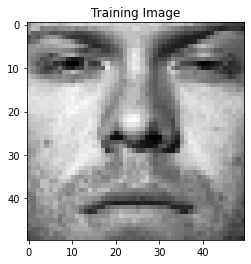

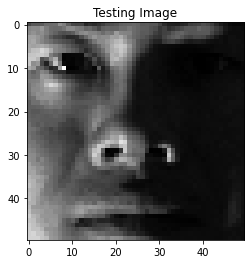

In [1]:
import numpy as np
from scipy import misc
import imageio
from matplotlib import pylab as plt
import matplotlib.cm as cm
%matplotlib inline

train_labels, train_data = [], []

test_labels, test_data = [], []

#training
for line in open('./faces/train.txt'):
    im = imageio.imread(line.strip().split()[0])
    train_data.append(im.reshape(2500,))
    train_labels.append(line.strip().split()[1])
train_data, train_labels = np.array(train_data, dtype=float), np.array(train_labels, dtype=int)
print(train_data.shape, train_labels.shape)

#testing
for line in open('./faces/test.txt'):
    im = imageio.imread(line.strip().split()[0])
    test_data.append(im.reshape(2500,))
    test_labels.append(line.strip().split()[1])
test_data, test_labels = np.array(test_data, dtype=float), np.array(test_labels, dtype=int)
print(test_data.shape, test_labels.shape)



plt.imshow(train_data[10, :].reshape(50,50), cmap = cm.Greys_r)
plt.title('Training Image')
plt.show()


plt.imshow(test_data[10, :].reshape(50,50), cmap = cm.Greys_r)
plt.title('Testing Image')
plt.show()

### 1C) Average Face

In [2]:
avg_face=np.mean(np.array(train_data), axis=0)

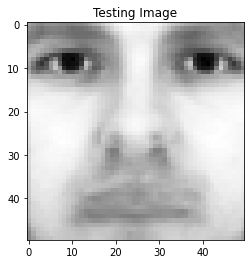

In [3]:
plt.imshow(avg_face.reshape(50,50), cmap = cm.Greys_r)
plt.title('Testing Image')
plt.show()

### 1D) Mean Subtraction

In [4]:
train_data_different_from_avg = [0]*540
for i in range(train_data.shape[0]):  # iterate over rows
    train_data_different_from_avg[i] = train_data[i] - avg_face
train_data_different_from_avg = np.array(train_data_different_from_avg)

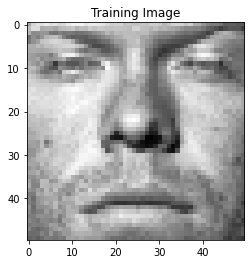

In [5]:
plt.imshow(train_data_different_from_avg[10, :].reshape(50,50), cmap = cm.Greys_r)
plt.title('Training Image')
plt.show()

In [6]:
test_data_different_from_avg = test_data.copy()
for i in range(test_data.shape[0]):  # iterate over rows
    test_data_different_from_avg[i] = test_data[i] - avg_face

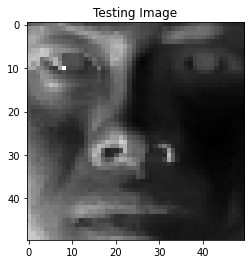

In [7]:
plt.imshow(test_data_different_from_avg[10, :].reshape(50,50), cmap = cm.Greys_r)
plt.title('Testing Image')
plt.show()

### 1E) Eigendecomposition for Training and Testing sets

In [8]:
test_data_different_from_avg[10, :].reshape(50,50).shape

(50, 50)

In [11]:
from numpy import linalg as LA

In [12]:
def eigen_decomp(x_matrix):
    Sigma = x_matrix.T.dot(x_matrix) / x_matrix.shape[0] # form covariance matrix
    u, s, vt = np.linalg.svd(Sigma, full_matrices=True) # perform eigendecomposition
    return vt

In [13]:
eigendecomp_train = np.real(eigen_decomp(train_data_different_from_avg))
eigendecomp_test = np.real(eigen_decomp(test_data_different_from_avg))

In [14]:
eigendecomp_train.shape

(2500, 2500)

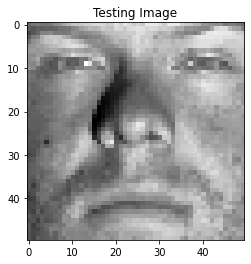

In [15]:
plt.imshow(train_data_different_from_avg[1, :].reshape(50, 50), cmap = cm.Greys_r)
plt.title('Testing Image')
plt.show()

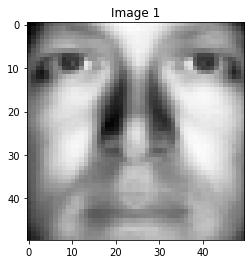

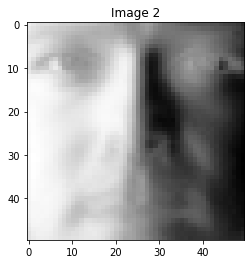

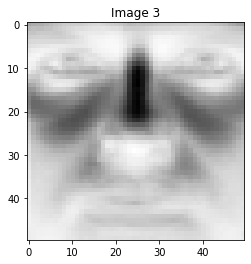

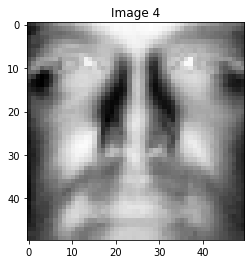

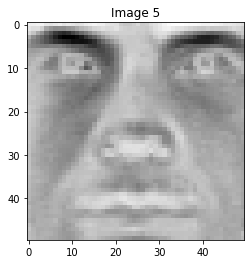

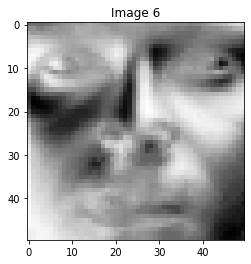

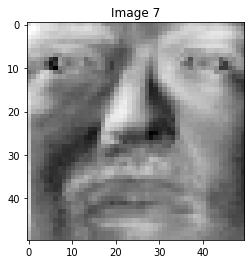

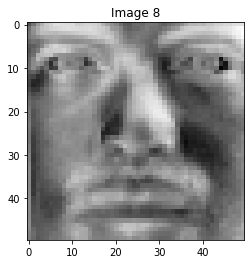

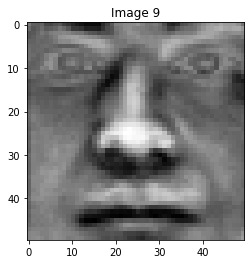

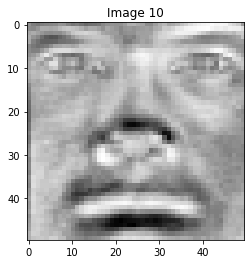

In [16]:
for i in range(0,10):
    plt.imshow(eigendecomp_train[i, :].reshape(50, 50), cmap = cm.Greys_r)
    plt.title('Image {}'.format(str(i+1)))
    plt.show()

### 1F)  Eigenface Train and Test Features

In [17]:
def eigenface_feature(eigenvs, X_train, r):
    r_features = eigenvs[:,0:r] # get top p eigenvectors
    final_r_F_vectors = X_train.dot(r_features) # project on these eigenvectors
    return final_r_F_vectors

In [18]:
train_data_different_from_avg.shape

(540, 2500)

In [19]:
eigenfeatures_train = eigenface_feature(eigendecomp_train, train_data_different_from_avg, 10)
eigenfeatures_test = eigenface_feature(eigendecomp_test, test_data_different_from_avg, 10)

In [20]:
eigenfeatures_train.shape

(540, 10)

In [21]:
eigenfeatures_test.shape

(100, 10)

### 1G) Facial Recognition

#### Logistic Regression on Training and Test sets (r=10)

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

In [23]:
y_train = train_labels
y_test = test_labels

logreg = LogisticRegression()
logreg.fit(eigenfeatures_train, y_train)
print('Classification Accuracy on training data (r = 10):', logreg.score(eigenfeatures_train, y_train))

print('Classification Accuracy on test data (r = 10):', logreg.score(eigenfeatures_test, y_test))

Classification Accuracy on training data (r = 10): 0.5296296296296297
Classification Accuracy on test data (r = 10): 0.16


/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


#### One-vs-Rest Logistic Regression on Training and Test sets (r=1, 2, ..., 200)

In [32]:
y_train = train_labels
y_test = test_labels

r = [i for i in range(1, 200)]

test_accuracies = []
train_accuracies = []

for r_val in r:
    
    #get r eigenfeatures
    eigenfeatures_train = eigenface_feature(eigendecomp_train, train_data_different_from_avg, r_val)
    eigenfeatures_test = eigenface_feature(eigendecomp_test, test_data_different_from_avg, r_val)
    
    #train classifier, use one-v-rest
    logreg2 = LogisticRegression(multi_class = 'ovr', solver = 'lbfgs', max_iter = 200)
    logreg2.fit(eigenfeatures_train, y_train)

    #predict and store accuracy
    train_accuracies.append(logreg2.score(eigenfeatures_train, y_train))
    test_accuracies.append(logreg2.score(eigenfeatures_test, y_test))

/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: C

/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: C

/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: C

/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: C

/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: C

/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: C

/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: C

/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: C

/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: C

/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: C

/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: C

/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: C

/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: C

/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: C

/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: C

/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: C

/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: C

/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: C

/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: C

/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: C

/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: C

/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: C

/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: C

/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: C

/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: C

/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: C

/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: C

/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: C

/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: C

/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: C

/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: C

/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: C

/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: C

/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: C

/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: C

/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: C

/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: C

/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: C

/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: C

/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/kristenflaherty/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: C

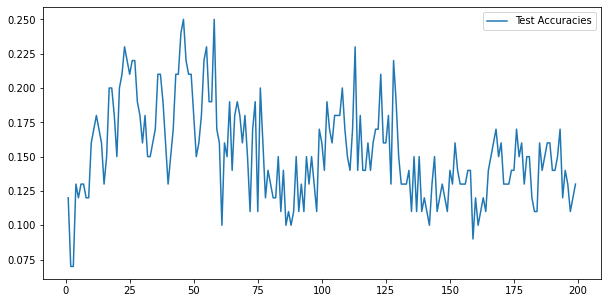

In [33]:
plt.figure(figsize=(10,5))
plt.plot(r, test_accuracies, label='Test Accuracies')
# plt.plot(r, train_accuracies, label='Train Accuracies')
plt.legend()
plt.show()

## EM Algorithm

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv('faithful.csv')
df = df.drop(columns=['Unnamed: 0'])

In [2]:
df.head()

,eruptions,waiting
0,3.600,79
1,1.800,54
2,3.333,74
3,2.283,62
4,4.533,85


### 2A) Plot datapoints as 2-D vectors

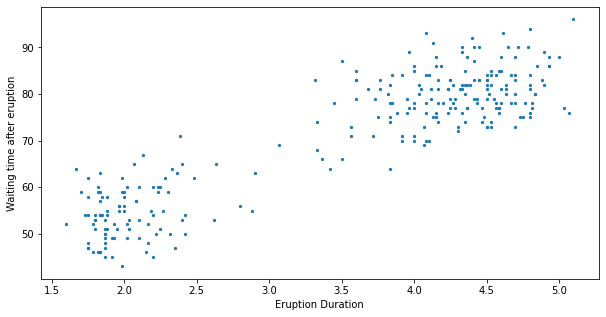

In [3]:
plt.figure(figsize=(10, 5))

plt.scatter(df['eruptions'], df['waiting'], s =5)
plt.xlabel('Eruption Duration')
plt.ylabel('Waiting time after eruption')
plt.show()

In [4]:
X = df.to_numpy()

In [5]:
X.shape

(272, 2)

### 2B) EM E-Step: find theta

In [6]:
from scipy.stats import multivariate_normal

In [7]:
def e_step(X, lis1):#mus, sigmas, pis
    m1=lis1[0]
    m2=lis1[1]
    cov1=lis1[2]
    cov2=lis1[3]
    pi=lis1[4]
    
    pt2 = multivariate_normal.pdf(X, mean=m2, cov=cov2)
    pt1 = multivariate_normal.pdf(X, mean=m1, cov=cov1)
    w1 = pi * pt2
    w2 = (1-pi) * pt1
    eval1 = w1/(w1+w2)

    return(eval1)

### 2C) EM M-Step: compute new mu, sigma

In [8]:
def m_step(X, eval1):
    num_mu1,din_mu1,num_mu2,din_mu2=0,0,0,0

    for i in range(0,len(X)):
        num_mu1 += (1-eval1[i]) * X[i]
        din_mu1 += (1-eval1[i])

        num_mu2 += eval1[i] * X[i]
        din_mu2 += eval1[i]

    mu1 = num_mu1/din_mu1
    mu2 = num_mu2/din_mu2

    num_s1,din_s1,num_s2,din_s2=0,0,0,0
    for i in range(0,len(X)):

        q1 = np.matrix(X[i]-mu1)
        num_s1 += (1-eval1[i]) * np.dot(q1.T, q1)
        din_s1 += (1-eval1[i])

        q2 = np.matrix(X[i]-mu2)
        num_s2 += eval1[i] * np.dot(q2.T, q2)
        din_s2 += eval1[i]

    s1 = num_s1/din_s1
    s2 = num_s2/din_s2

    pi = sum(eval1)/len(X)
    
    lis2=[mu1,mu2,s1,s2,pi]
    return(lis2)

### 2D) Implement and run EM

In [9]:
#initialize params
mus = X[np.random.choice(X.shape[0], size=2), :]
pis = np.ones(shape=(2), dtype=np.float)/2
sigmas = np.zeros(shape=(2, 2), dtype=np.float)
for c in range(2):
    sigmas[:, c] = np.var(X[:, c])/10

In [11]:
iterations = 40
lis1=[mus[0],mus[1],sigmas[0],sigmas[1],pis[0]]
means = [[],
         []]
for i in range(0,iterations):
    thetas = e_step(X, lis1)
    lis2 = m_step(X, thetas)
    
    if list(lis2[0]) in means[0] and list(lis2[1]) in means[1]:
        print(i)
        break
    means[0].append(list(lis2[0]))
    means[1].append(list(lis2[1]))
    lis1=lis2

37


#### **Convergence and iteration reasoning:**

Converges around 35 iterations, as seen in the printout: when the mu and sigma remain constant after a new iteration,  the evaluated thetas no longer find new gaussians in each class, and the model has converged. When each new mean calculated in the m step for each class equals the previous mean for the respective classes, the loop breaks and the model reaches convergence.

### Mean trajectories

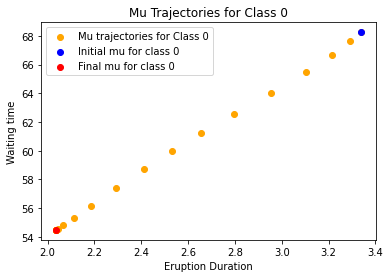

In [12]:
plt.scatter( x=[means[0][i][0] for i in range(len(means[0]))], y = [means[0][i][1] for i in range(len(means[0]))], label='Mu trajectories for Class 0', c='orange')
plt.scatter( x=means[0][0][0], y = means[0][0][1], label='Initial mu for class 0', c='b')
plt.scatter( x=means[0][-1][0], y = means[0][-1][1], label='Final mu for class 0', c='r')
plt.legend()
plt.title('Mu Trajectories for Class 0')
plt.xlabel('Eruption Duration')
plt.ylabel('Waiting time')
plt.show()

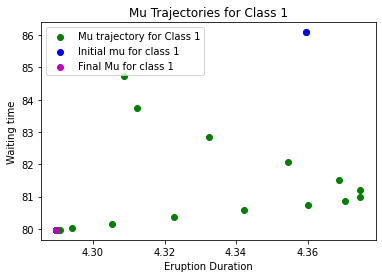

In [13]:
plt.scatter([means[1][i][0] for i in range(len(means[1]))], y = [means[1][i][1] for i in range(len(means[0]))], label='Mu trajectory for Class 1', c='g')
plt.scatter( x=means[1][0][0], y = means[1][0][1], label='Initial mu for class 1', c='b')
plt.scatter( x=means[1][-1][0], y = means[1][-1][1], label='Final Mu for class 1', c='m')
plt.legend()
plt.title('Mu Trajectories for Class 1')
plt.xlabel('Eruption Duration')
plt.ylabel('Waiting time')
plt.show()

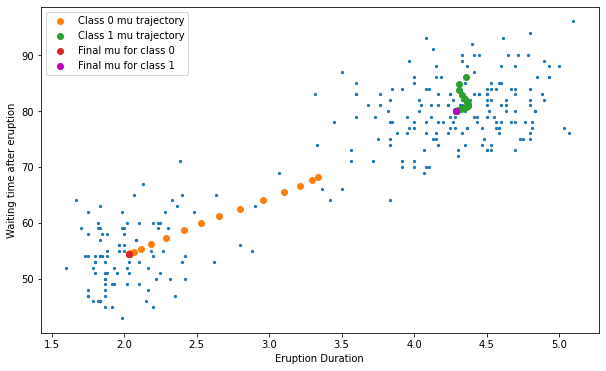

In [14]:
plt.figure(figsize=(10, 6))

plt.scatter(df['eruptions'], df['waiting'], s =5)
plt.scatter( x=[means[0][i][0] for i in range(len(means[0]))], y = [means[0][i][1] for i in range(len(means[0]))], label='Class 0 mu trajectory')
plt.scatter( x=[means[1][i][0] for i in range(len(means[1]))], y = [means[1][i][1] for i in range(len(means[1]))], label='Class 1 mu trajectory')
plt.scatter( x=means[0][-1][0], y = means[0][-1][1], label='Final mu for class 0')
plt.scatter( x=means[1][-1][0], y = means[1][-1][1], label='Final mu for class 1', c='m')
plt.xlabel('Eruption Duration')
plt.ylabel('Waiting time after eruption')
plt.legend()
plt.show()

Resources:
https://github.com/kitteltom/old-faithful-EM/blob/main/EM_gaussian_mixture.ipynb
https://medium.com/@prateek.shubham.94/expectation-maximization-algorithm-7a4d1b65ca55

### 2E) K means

In [60]:
from sklearn.cluster import KMeans

In [61]:
kmeans = KMeans(n_clusters=2).fit(df)

In [62]:
kmeans.cluster_centers_

array([[ 4.29793023, 80.28488372],
       [ 2.09433   , 54.75      ]])

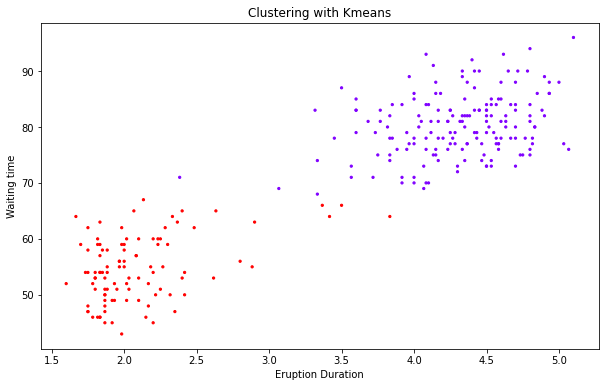

In [63]:
plt.figure(figsize = (10, 6))
plt.scatter(df['eruptions'],df['waiting'], c=kmeans.labels_, cmap='rainbow', s = 5)
plt.title('Clustering with Kmeans')
plt.xlabel('Eruption Duration')
plt.ylabel('Waiting time')
plt.show()

### **Comparison of results between EM and KMeans:**
- EM will generate more accurate class boundaries and cluster centers because of its iterative method and reliance on maximizing the log likelihood. EM will likely create more accurate class boundaries in areas where its uncertain of which class the mix of points should fall.
- Results will change between these two methods because the number of classes each method generates will be different (depending on what k is set to in KMeans). Additionally, the decision boundaries for each cluster in KMeans and EM will be different, yielding different results: KMeans decision boundaries are more circular while EM decision boundaries can be any shape (linear, non linear, etc.)
- Kmeans output soft assignments for the means of each cluster, while EM algorithms output the most accurate cluster mean centers depending on a good objective function.

### Visual Comparison of Results

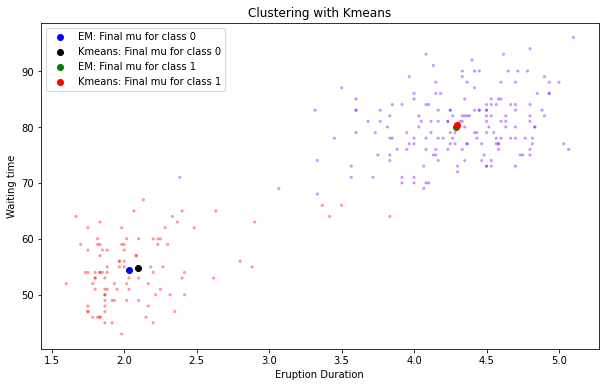

In [70]:
plt.figure(figsize = (10, 6))
plt.scatter(df['eruptions'],df['waiting'], c=kmeans.labels_, cmap='rainbow', s = 5, alpha=0.3)
plt.scatter( x=means[0][-1][0], y = means[0][-1][1], label='EM: Final mu for class 0', c='b')
plt.scatter( x=kmeans.cluster_centers_[1][0], y = kmeans.cluster_centers_[1][1], label='Kmeans: Final mu for class 0', c='black')
plt.scatter( x=means[1][-1][0], y = means[1][-1][1], label='EM: Final mu for class 1', c='g')
plt.scatter( x=kmeans.cluster_centers_[0][0], y = kmeans.cluster_centers_[0][1], label='Kmeans: Final mu for class 1', c='red')
plt.title('Clustering with Kmeans')
plt.xlabel('Eruption Duration')
plt.ylabel('Waiting time')
plt.legend()
plt.show()